In [6]:
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# For evaluation
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, models

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import Input  # Explicitly import the Input layer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# General utilities
import warnings
warnings.filterwarnings("ignore")
from PIL import ImageFile
from PIL import Image

In [7]:
# # Handle truncated images
# ImageFile.LOAD_TRUNCATED_IMAGES = True

# Seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define base directory for dataset
base_dir = 'C:/Users/tahas/Desktop/assign1/chest_xray' 
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

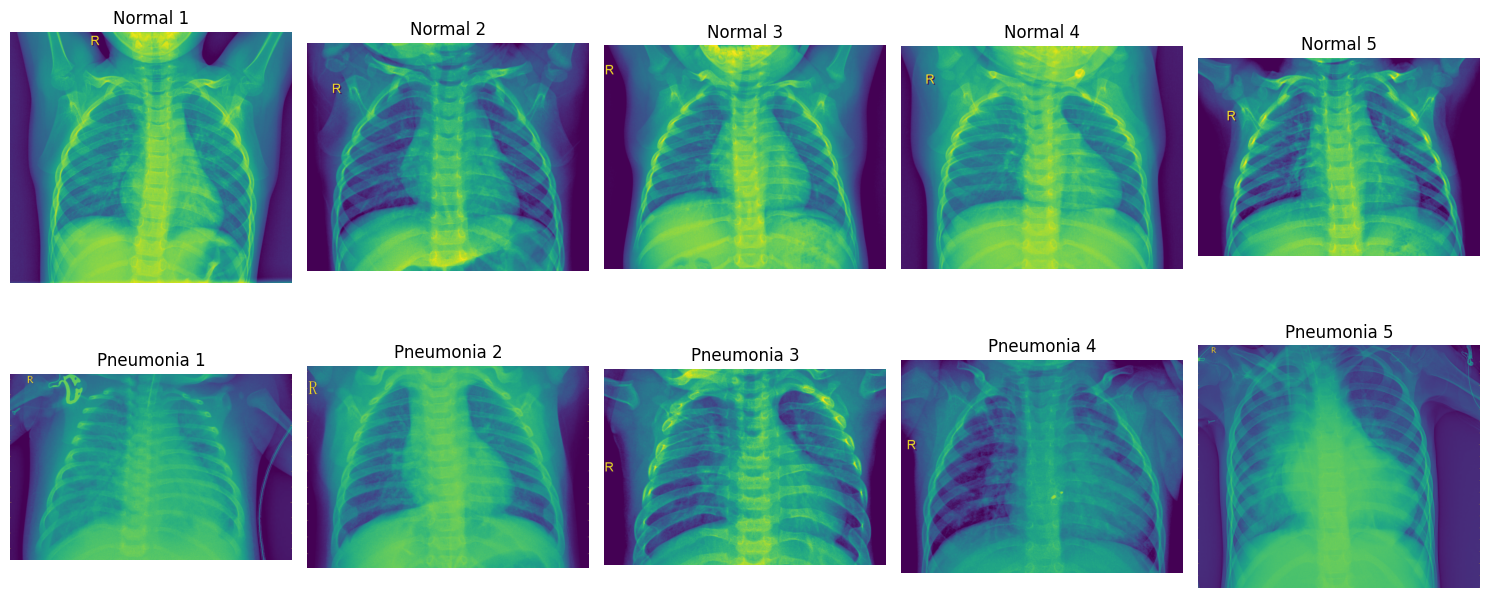

In [8]:
train_normal_dir = os.path.join(train_dir, 'NORMAL')
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')

# Get sample imgs for every class
normal_images = os.listdir(train_normal_dir)[:5]  # Get the first 5 images from normal class
pneumonia_images = os.listdir(train_pneumonia_dir)[:5]  # Get the first 5 images from pneumonia class

# Create subplots for iamges
fig, axes = plt.subplots(2, 5, figsize=(15, 7))

# Display normal class imgs
for i, img_name in enumerate(normal_images):
    img_path = os.path.join(train_normal_dir, img_name)
    img = mpimg.imread(img_path)
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Normal {i+1}")

# Display pneumonia class imgs
for i, img_name in enumerate(pneumonia_images):
    img_path = os.path.join(train_pneumonia_dir, img_name)
    img = mpimg.imread(img_path)
    axes[1, i].imshow(img)
    axes[1, i].axis('off')
    axes[1, i].set_title(f"Pneumonia {i+1}")

# Display the plot
plt.tight_layout()
plt.show()

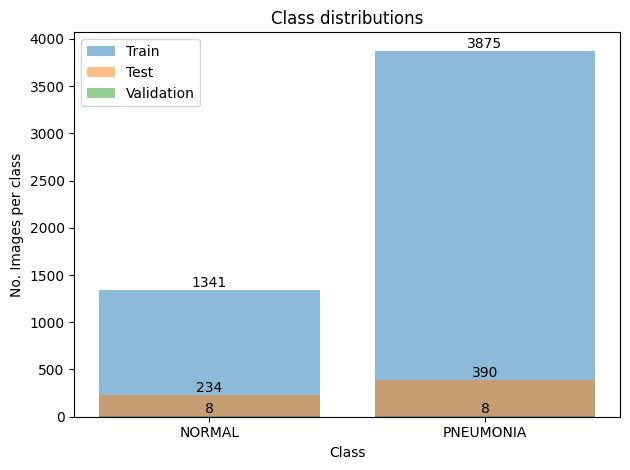

In [3]:
#Visualize classdistributions
def count_classes(directory):
  return {class_name: len(os.listdir(os.path.join(directory, class_name)))
      for class_name in os.listdir(directory) if os.path.isdir(os.path.join(directory, class_name))}

train_counts = count_classes(train_dir)
validation_counts = count_classes(validation_dir)
test_counts = count_classes(test_dir)


bar1 = plt.bar(train_counts.keys(), train_counts.values(), label='Train', alpha=0.5)

bar2 = plt.bar(test_counts.keys(), test_counts.values(), label='Test', alpha=0.5)
bar3 = plt.bar(validation_counts.keys(), validation_counts.values(), label='Validation', alpha=0.5)

# Function to add labels to bar charts
def add_labels(bars):
  for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + .05, yval, ha='center', va='bottom')

# Adding the labels to the each bar
add_labels(bar1)
add_labels(bar2)
add_labels(bar3)

plt.title('Class distributions')
plt.xlabel('Class')
plt.ylabel('No. Images per class')
plt.legend()
plt.tight_layout()
plt.show()

In [37]:
# import os
# import shutil
# from sklearn.model_selection import train_test_split

# Define paths for dataset
base_dir = 'C:/Users/tahas/Desktop/assign1/chest_xray'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Combine all data into a single list with labels
def gather_data_and_labels(directory):
    data = []
    labels = []
    class_names = ['NORMAL', 'PNEUMONIA']
    
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        for file in os.listdir(class_path):
            if file.endswith(('.jpg', '.png', '.jpeg')):  # Cechking file extensions, only valid ones allowed like png jpg and jpeg
                data.append(os.path.join(class_path, file))
                labels.append(class_name)
    
    return data, labels

# After manually splittign get the data
train_data, train_labels = gather_data_and_labels(train_dir)
val_data, val_labels = gather_data_and_labels(validation_dir)
test_data, test_labels = gather_data_and_labels(test_dir)

# Combine all data and labelss
all_data = train_data + val_data + test_data
all_labels = train_labels + val_labels + test_labels

# Labeling class to numbers
label_mapping = {'NORMAL': 0, 'PNEUMONIA': 1}
all_labels = [label_mapping[label] for label in all_labels]

# Split data into 70% train, 15% validation, and 15% test
train_files, temp_files, train_labels, temp_labels = train_test_split(
    all_data, all_labels, test_size=0.3, stratify=all_labels, random_state=42
)
val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

# Function to copy files into a target directory
def copy_files(file_list, label_list, target_dir):
    os.makedirs(target_dir, exist_ok=True)
    for label in label_mapping.keys():  # Create subdirectories for each class
        os.makedirs(os.path.join(target_dir, label), exist_ok=True)
    
    for file, label in zip(file_list, label_list):
        label_name = [key for key, value in label_mapping.items() if value == label][0]
        shutil.copy(file, os.path.join(target_dir, label_name, os.path.basename(file)))

# Copy files to to new directories insmae folder
final_train_dir = os.path.join(base_dir, 'final_train')
final_val_dir = os.path.join(base_dir, 'final_val')
final_test_dir = os.path.join(base_dir, 'final_test')

copy_files(train_files, train_labels, final_train_dir)
copy_files(val_files, val_labels, final_val_dir)
copy_files(test_files, test_labels, final_test_dir)

print(f"Data successfully split into:")
print(f"Train: {len(train_files)} samples")
print(f"Validation: {len(val_files)} samples")
print(f"Test: {len(test_files)} samples")


Data successfully split into:
Train: 4099 samples
Validation: 878 samples
Test: 879 samples


In [4]:
# Define the paths to new dir
final_train_dir = os.path.join(base_dir, 'final_train')
final_val_dir = os.path.join(base_dir, 'final_val')
final_test_dir = os.path.join(base_dir, 'final_test')

# Augmenting trrianing data
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255  # Normalize pixel values
)

# Rescale validation and test data no augmentation
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    final_train_dir,
    target_size=(224, 224),  # Resize images to 224x224
    batch_size=32,          # Batch size
    class_mode='binary',    
    shuffle=True            # Shuffle training data
)

validation_generator = val_test_datagen.flow_from_directory(
    final_val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False           
)

test_generator = val_test_datagen.flow_from_directory(
    final_test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False           
)

# Print the class indices for reference
print("Class indices:", train_generator.class_indices)


Found 4099 images belonging to 2 classes.
Found 878 images belonging to 2 classes.
Found 879 images belonging to 2 classes.
Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}


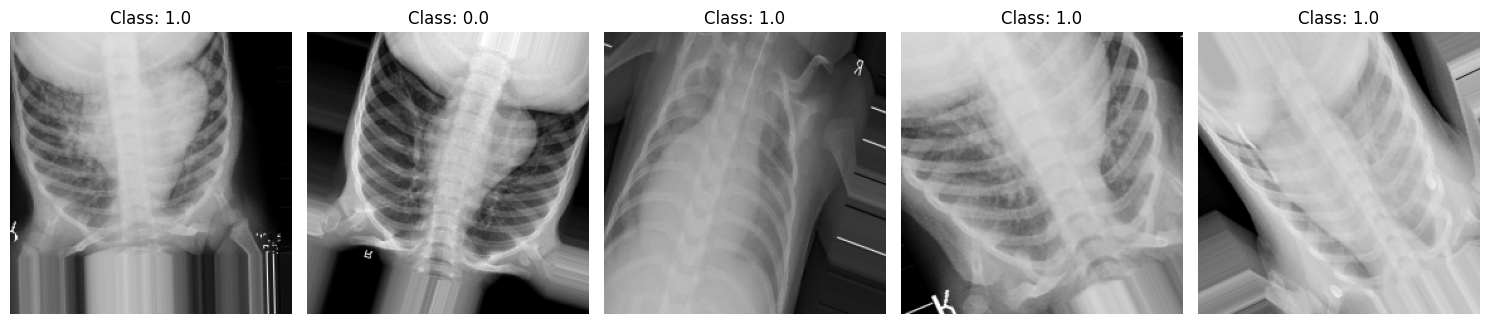

In [5]:
x_batch, y_batch = next(train_generator)
fig, axes = plt.subplots(1, 5, figsize=(15, 15))

for i in range(5):
    axes[i].imshow(x_batch[i])
    axes[i].axis('off')
    axes[i].set_title(f"Class: {y_batch[i]}")

plt.tight_layout()
plt.show()

In [6]:
dict_class = train_generator.class_indices
print('Dictionary: {}'.format(dict_class))
class_names = list(dict_class.keys())  
print('Class labels: {}'.format(class_names))

Dictionary: {'NORMAL': 0, 'PNEUMONIA': 1}
Class labels: ['NORMAL', 'PNEUMONIA']


In [7]:
#Distribute class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(train_generator.classes), y= train_generator.classes)
class_weights = dict(zip(np.unique(train_generator.classes), class_weights))
class_weights

{0: 1.8497292418772564, 1: 0.6852223336676697}

In [8]:
# Maintain learnign rate same for all model funcitons
LEARNING_RATE = 1e-4

def create_vgg16(input_shape=(224, 224, 3), num_classes=1):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the pre-trained layers

    # Add additional convolutional layers for grad cam, without cannot compute
    additional_layers = Sequential([
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2))
    ])

    model = Sequential([
        base_model,
        additional_layers,
        layers.GlobalAveragePooling2D(),  # Reduce spatial dimensions
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),  # Regularization
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')  # Binary or multi-class
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy' if num_classes == 1 else 'categorical_crossentropy',
        metrics=['accuracy']
    )
    print('VGG16 Summary:')
    model.summary()
    return model
    
def create_googlenet(input_shape=(224, 224, 3), num_classes=1):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the pre-trained layers

    # Add additional convolutional layers for grad cam, without cannot compute
    additional_layers = Sequential([
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2))
    ])

    model = Sequential([
        base_model,
        additional_layers,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')  # Binary or multi-class
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy' if num_classes == 1 else 'categorical_crossentropy',
        metrics=['accuracy']
    )
    print('InceptionV3 Summary:')
    model.summary()
    return model

def create_lenet5(input_shape=(224, 224, 3), num_classes=1):
    model = Sequential([
        layers.Conv2D(32, (5, 5), activation='relu', input_shape=input_shape, padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, (5, 5), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, (5, 5), activation='relu'),
        layers.Flatten(),
        layers.Dense(120, activation='relu'),
        layers.Dense(84, activation='relu'),
        layers.Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')  # Binary or multi-class
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy' if num_classes == 1 else 'categorical_crossentropy',
        metrics=['accuracy']
    )
    print('Lenet5 Summary:')
    model.summary()
    return model

vgg16_model = create_vgg16(input_shape=(224, 224, 3), num_classes=1)
googlenet_model = create_googlenet(input_shape=(224, 224, 3), num_classes=1)
lenet5_model = create_lenet5(input_shape=(224, 224, 3), num_classes=1)

VGG16 Summary:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 sequential (Sequential)     (None, 3, 3, 512)         4719616   
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                       

In [9]:

# from sklearn.metrics import classification_report, confusion_matrix, f1_score
# import seaborn as sns
# import matplotlib.pyplot as plt

# Train and Evaluate our model using this function
def train_and_evaluate(model, model_name, train_generator, validation_generator, test_generator, class_weights=None):
    print(f"Training {model_name} for 10 epochs")
    
    # Early stopping after 3 epocs for reducing overfit
    early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

    # Learning rate scheduler after 3 epocs for reducing overfit
    lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

    # Fit the model with both callbacks
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        class_weight=class_weights,
        callbacks=[early_stopping, lr_scheduler]
    )

    # Evaluate the model
    test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
    print(f"{model_name} Test Accuracy: {test_acc * 100:.2f}%")

    # Predictions 
    test_generator.reset()
    predictions = (model.predict(test_generator) > 0.5).astype(int).flatten()
    true_classes = test_generator.classes

    # F1 Score
    f1 = f1_score(true_classes, predictions)
    print(f"{model_name} F1 Score: {f1:.2f}")

    # Classification Report
    target_names = list(test_generator.class_indices.keys())
    report = classification_report(true_classes, predictions, target_names=target_names)
    print("\nClassification Report:")
    print(report)

    # Confusion Matrix
    cm = confusion_matrix(true_classes, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return history


Training LeNet-5 for 10 epochs
Epoch 1/10
128/128 [==============================] - 86s 628ms/step - loss: 0.4733 - accuracy: 0.7706 - val_loss: 0.4123 - val_accuracy: 0.7766 - lr: 1.0000e-04
Epoch 2/10
128/128 [==============================] - 80s 619ms/step - loss: 0.3613 - accuracy: 0.8279 - val_loss: 0.3916 - val_accuracy: 0.7905 - lr: 1.0000e-04
Epoch 3/10
128/128 [==============================] - 79s 619ms/step - loss: 0.3113 - accuracy: 0.8657 - val_loss: 0.3656 - val_accuracy: 0.8113 - lr: 1.0000e-04
Epoch 4/10
128/128 [==============================] - 80s 623ms/step - loss: 0.2924 - accuracy: 0.8729 - val_loss: 0.2988 - val_accuracy: 0.8646 - lr: 1.0000e-04
Epoch 5/10
128/128 [==============================] - 80s 621ms/step - loss: 0.2844 - accuracy: 0.8793 - val_loss: 0.3211 - val_accuracy: 0.8542 - lr: 1.0000e-04
Epoch 6/10
128/128 [==============================] - 80s 624ms/step - loss: 0.2883 - accuracy: 0.8763 - val_loss: 0.2571 - val_accuracy: 0.8819 - lr: 1.0000e-

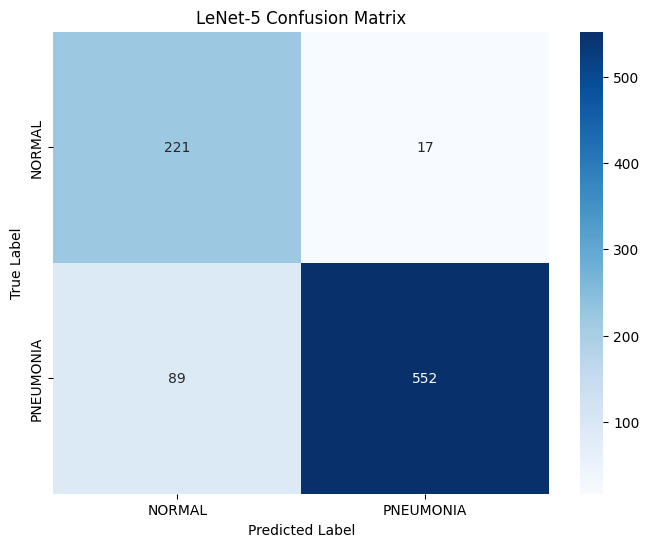

In [10]:
# Train and evaluate each model
train_and_evaluate(lenet5_model, "LeNet-5", train_generator, validation_generator, test_generator)


Training VGG-16 for 10 epochs
Epoch 1/10
128/128 [==============================] - 87s 630ms/step - loss: 0.4124 - accuracy: 0.8033 - val_loss: 0.2637 - val_accuracy: 0.8900 - lr: 1.0000e-04
Epoch 2/10
128/128 [==============================] - 85s 660ms/step - loss: 0.2969 - accuracy: 0.8736 - val_loss: 0.2399 - val_accuracy: 0.9086 - lr: 1.0000e-04
Epoch 3/10
128/128 [==============================] - 80s 623ms/step - loss: 0.2545 - accuracy: 0.9036 - val_loss: 0.2843 - val_accuracy: 0.8831 - lr: 1.0000e-04
Epoch 4/10
128/128 [==============================] - 81s 628ms/step - loss: 0.2320 - accuracy: 0.9056 - val_loss: 0.2362 - val_accuracy: 0.9039 - lr: 1.0000e-04
Epoch 5/10
128/128 [==============================] - 80s 624ms/step - loss: 0.2153 - accuracy: 0.9171 - val_loss: 0.3068 - val_accuracy: 0.8553 - lr: 1.0000e-04
Epoch 6/10
128/128 [==============================] - 81s 632ms/step - loss: 0.1991 - accuracy: 0.9194 - val_loss: 0.1725 - val_accuracy: 0.9352 - lr: 1.0000e-0

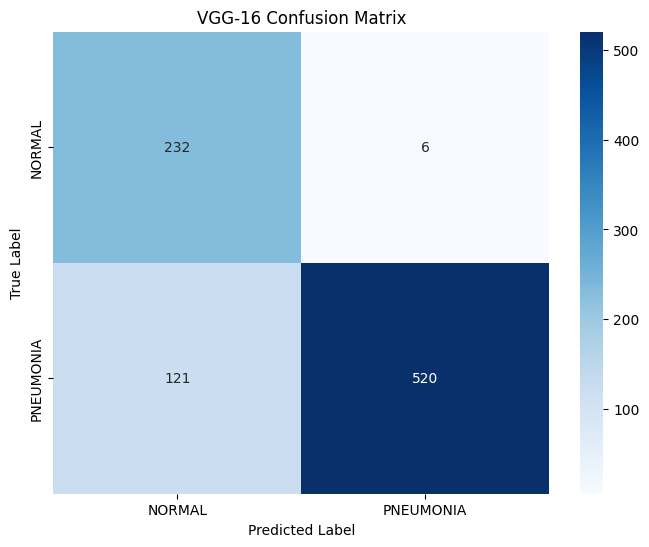

In [13]:
train_and_evaluate(vgg16_model, "VGG-16", train_generator, validation_generator, test_generator)


Training GoogLeNet for 10 epochs
Epoch 1/10
128/128 [==============================] - 87s 643ms/step - loss: 0.3032 - accuracy: 0.8638 - val_loss: 0.2555 - val_accuracy: 0.8958 - lr: 1.0000e-04
Epoch 2/10
128/128 [==============================] - 85s 661ms/step - loss: 0.2566 - accuracy: 0.8933 - val_loss: 0.2151 - val_accuracy: 0.9190 - lr: 1.0000e-04
Epoch 3/10
128/128 [==============================] - 86s 676ms/step - loss: 0.2336 - accuracy: 0.9048 - val_loss: 0.1967 - val_accuracy: 0.9248 - lr: 1.0000e-04
Epoch 4/10
128/128 [==============================] - 81s 636ms/step - loss: 0.2315 - accuracy: 0.9044 - val_loss: 0.2543 - val_accuracy: 0.8854 - lr: 1.0000e-04
Epoch 5/10
128/128 [==============================] - 82s 642ms/step - loss: 0.2101 - accuracy: 0.9130 - val_loss: 0.2170 - val_accuracy: 0.9039 - lr: 1.0000e-04
Epoch 6/10
128/128 [==============================] - 86s 670ms/step - loss: 0.2041 - accuracy: 0.9201 - val_loss: 0.2623 - val_accuracy: 0.8773 - lr: 1.0000

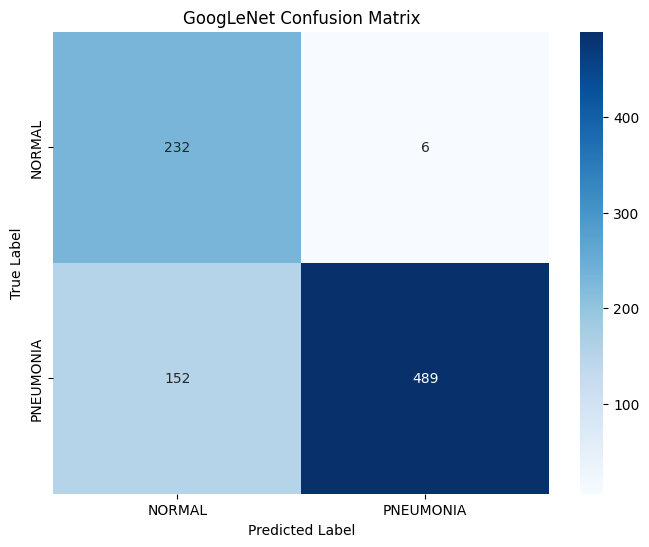

In [14]:
train_and_evaluate(googlenet_model, "GoogLeNet", train_generator, validation_generator, test_generator)

In [11]:
# Save the model
lenet5_model.save('C:/Users/tahas/Desktop/xai final/lenet5_model.h5')  # HDF5 format


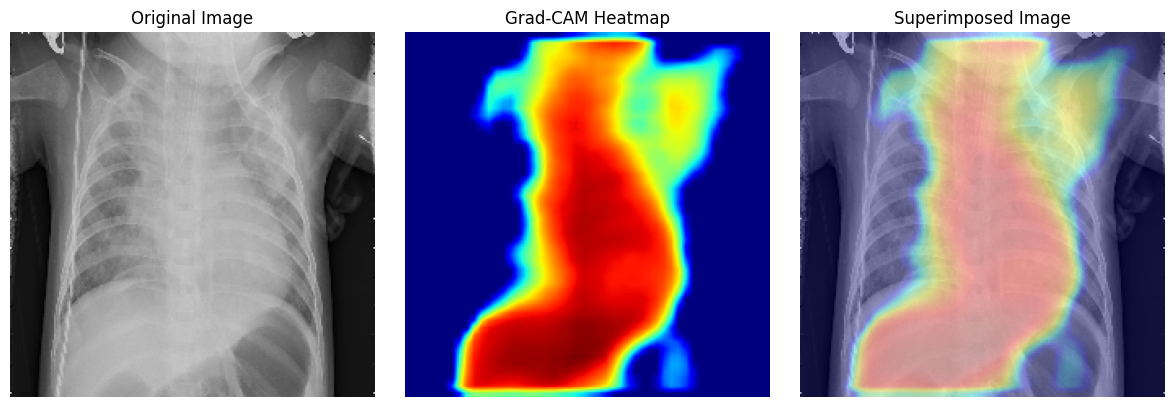

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to apply Grad-CAM
def apply_gradcam(model, img, last_conv_layer_name):
    grad_model = Model(inputs=model.input, 
                       outputs=[model.get_layer(last_conv_layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(img, axis=0))
        top_pred_idx = tf.argmax(predictions[0])
        top_class_output = predictions[:, top_pred_idx]
    
    grads = tape.gradient(top_class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(pooled_grads * conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)  # Normalize heatmap
    return heatmap

# Function to plot the results
def plot_gradcam_full(img, heatmap, alpha=0.4):
    heatmap_resized = tf.image.resize(tf.expand_dims(heatmap, axis=-1), (img.shape[0], img.shape[1]))
    heatmap_resized = tf.squeeze(heatmap_resized).numpy()
    heatmap_colormap = plt.cm.jet(heatmap_resized)[:, :, :3]  # Get RGB channels
    superimposed_img = heatmap_colormap * alpha + img
    superimposed_img = superimposed_img / np.max(superimposed_img)  # Normalize
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(img)
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(heatmap_resized, cmap='jet')
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.title("Superimposed Image")
    plt.imshow(superimposed_img)
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Load and preprocess the img file
def load_and_preprocess_image(image_path, target_size=(224, 224)):

    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
    return img_array, img

# Get file path for an example img
image_path = r"C:/Users/tahas/Desktop/xai/final_test/PNEUMONIA/person119_bacteria_566.jpeg"

# Load and preprocess the image
img_array, img_original = load_and_preprocess_image(image_path)

# Apply Grad-CAM
last_conv_layer_name = "conv2d_100" 
heatmap = apply_gradcam(lenet5_model, img_array, last_conv_layer_name)

# Plot original image, heatmap, and superimposed image
plot_gradcam_full(img_array, heatmap)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


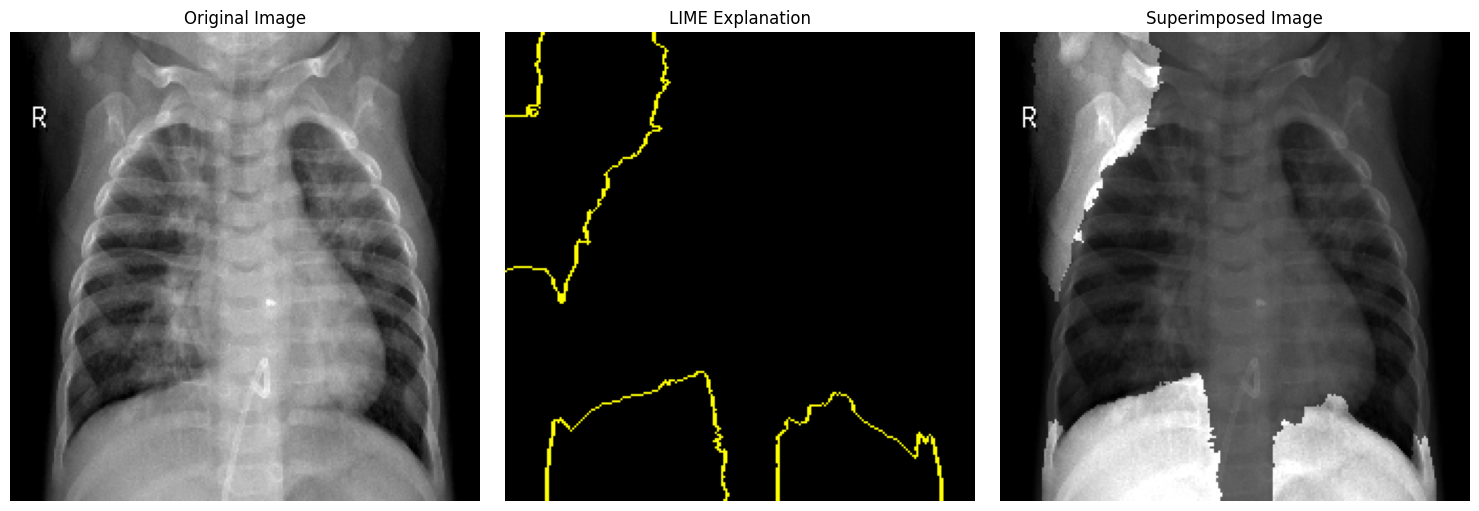

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to preprocess the img
def preprocess_image(image_path, target_size=(224, 224)):
    original_img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(original_img) / 255.0  # Normalize to [0, 1]
    return np.expand_dims(img_array, axis=0), original_img

# Function to explain prediction using LIME
def explain_with_lime(model, image_path, num_samples=1000):
    # Load and preprocess the image
    img_array, original_img = preprocess_image(image_path)
    
    # Define a LIME explainer
    explainer = lime_image.LimeImageExplainer()
    
    # Define a prediction function for LIME
    def predict_fn(images):
        images = images / 255.0  # Normalize the images if necessary
        return model.predict(images)
    
    # Generate explanation
    explanation = explainer.explain_instance(
        image=img_array[0],
        classifier_fn=predict_fn,
        top_labels=1,  
        hide_color=0,
        num_samples=num_samples
    )
    
    # Get the explanation and mask, lime needs mask for pertubing
    temp, mask = explanation.get_image_and_mask(
        label=explanation.top_labels[0], 
        positive_only=True, 
        hide_rest=False, 
        num_features=5, 
        min_weight=0.0
    )
    
    # Create a superimposed image
    superimposed_img = temp * mask[..., np.newaxis]  
    superimposed_img = np.clip(superimposed_img, 0, 1)  
    superimposed_img = superimposed_img + img_array[0] * 0.5  
    superimposed_img = np.clip(superimposed_img, 0, 1)  

    # Plotting all images in a row
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original_img)
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.title("LIME Explanation")
    plt.imshow(mark_boundaries(temp / 255.0, mask))
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.title("Superimposed Image")
    plt.imshow(superimposed_img)
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Take image from path, sample img
image_path = r"C:/Users/tahas/Desktop/xai/final_test/PNEUMONIA/person263_bacteria_1227.jpeg"

# Call the LIME explanation function
explain_with_lime(lenet5_model, image_path)
